# Model selection and final results
In this notebook we select the model with the best out-of-sample error and evaluate it on the test set which has never been seen by any of the models (the second half of 2017).

Although the time series + feature neural network achieved an impressive RMSE of aroound 400, using the best feature basis for the linear model along with the ARIMA model to account for some of the residual error we are able to achieve an RMSE of 350. We thus choose the linear model with ARIMA error, retrain it and provide test error metrics.

In [1]:
# Only necessary if running in colab
# You may need to restart your runtime
running_in_colab = 'google.colab' in str(get_ipython())
if running_in_colab:
  !pip install git+https://github.com/statsmodels/statsmodels
  !pip install Cython
  !pip install git+git://github.com/scikit-learn/scikit-learn.git

In [2]:
import os
import math # for the rmse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# In case you are running this in colab
# Add this to make it download
if running_in_colab:
  from google.colab import files 

In [3]:
# Create output directory
path = 'output_final'
if not os.path.exists(path):
  os.mkdir(path)

In [4]:
# We will use the last half-year as the test set
test_size = 365*12

In [5]:
# Import the design matrix
design_matrix = pd.read_csv("best_design_matrix.csv", delimiter=",", index_col=0)
# Make the columns categorical
design_matrix['isWeekend'] = design_matrix['isWeekend'].astype('category')
design_matrix['isHoliday'] = design_matrix['isHoliday'].astype('category')
X_train = design_matrix[:-test_size]
X_test = design_matrix[-test_size:]

In [6]:
# Import the electricity demand and set the training and testing label
data = pd.read_csv("MergedDataset.csv", delimiter=",", index_col=0)
data = data[data['Datetime'] >= '2012']
data = data[data['Datetime'] < '2018']
data.index = range(len(data))
y = data['Toronto']
y_train = y[:-test_size]
y_test = y[-test_size:]

In [7]:
print(y_train.shape, X_train.shape)
print(y_test.shape, X_test.shape)

(48228,) (48228, 176)
(4380,) (4380, 176)


In [8]:
# Train the linear model on all but the test set
lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

In [9]:
# Now train the ARIMA on the residual errors
# Recall the optimal order was (1, 0, 0) i.e. just an additional autoregression
# We don't use the wrapper function here just the original statsmodel fit and predict
order = (1, 0, 0)
ts_res = y_train - lm.predict(X_train)
arima = ARIMA(ts_res, order=order)
arima = arima.fit()

In [10]:
# Predict test labels and residuals with linear model and arima
y_pred = lm.predict(X_test)
start = len(y_train)
end = start + test_size
y_res_pred = arima.predict(start, end-1)
y_pred = y_pred + y_res_pred

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

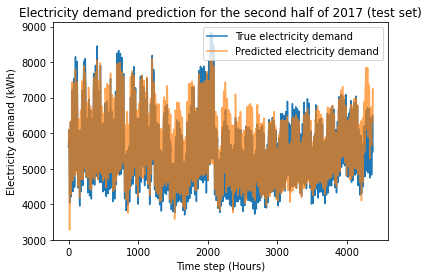

In [11]:
# We plot the true test set and the linear model prediction
y_test.index = range(len(y_test))
y_pred.index = range(len(y_pred))
plt.plot(y_test, label="True electricity demand")
plt.plot(y_pred, alpha=0.7, label="Predicted electricity demand");
plt.title("Electricity demand prediction for the second half of 2017 (test set)")
plt.xlabel("Time step (Hours)")
plt.ylabel("Electricity demand (kWh)")
plt.legend()
filename = path + "/final_prediction.png"
plt.savefig(filename)
if running_in_colab:
  files.download(filename)

In [12]:
# Compute the test time performance
mse = mean_squared_error(y_true=y_test, y_pred=y_pred)
rmse = math.sqrt(mse)

In [13]:
print(f"The test set rmse is {round(rmse, 4)}")

The test set rmse is 409.6702


In [14]:
# We also compute thte mean absolute percentage error to provide
# a more interpretable result
mape = 100 * np.abs((y_test - y_pred)/y_test).mean() 

In [15]:
print(f"The percentage error is {round(mape, 4)}%") # 

The percentage error is 5.9023%


With a test RMSE of 409 and a percentage error of 5.9% we believe that we have achieve satisfactory prediction performance.

C'est fini :)